# Single Agent Path Planning

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center
from panav.viz import draw_env
%load_ext autoreload
%autoreload 2

In [139]:
import shapely
import numpy as np
from matplotlib import pyplot as plt

start_locs = np.array([[-1,-1],[-2,-3]])
goal_locs = np.array([[9,9],[5,7]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]


In [140]:
limits = [(-10.0,10.0),(-10.0,10.0)]
o=Box2DRegion((0,3),(0,5))
p = PolygonRegion([[6,1],[10,2],[6,5]])
env = NavigationEnv(limits,[o,p],starts,goals)

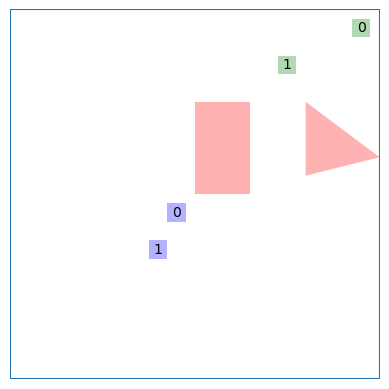

In [141]:
draw_env(env)

## Single agent path planning optimization problem(static, permanent obstacles only. Not considering moving/temporary obstacles)

$d$: spatial dimension.

$K$: constant, number of way points.

$\mathcal{X}^{start}, \mathcal{X}^{goal}$: start and goal regions, assume to be polytopes.

$\mathcal{X}:$ the workspace specified by the axis limits.

$v_\max:$ the upper bound on the agent's speed.

$t_0$: time stamp at the initial step.

Decision variables: $x_0,(t_1,x_1),(t_2,x_2),...,(t_K,x_K)$

The agent should arrive at $x_k$ at time $t_k$.

$\mathcal{O}_{1:N}:$ polytope obstacles.

The path planning problem for a single agent is

$$
\begin{aligned}
    &\min_{x_{0:K}\in \mathcal{X},~t_{1:K}} t_K\\
    s.t.& ~x_0\in \mathcal{X}^{start}, x_K\in  \mathcal{X}^{goal}\\
    &\overline{x_{k-1} x_{k}}\notin  \mathcal{O}_{i},~ \forall k\in 1:K,~i \in 1:N \\
 &||x_k-x_{k-1}||/(t_k-t_{k-1})\leq v_\max,~\forall k\in 1:K\\
 & t_k\geq t_{k-1},~\forall k\in 1:K
\end{aligned}
$$
 $\overline{x_{k-1} x_{k}}$ stands for the line segment with end points $x_{k-1},~x_{k}$.

### Modeling the obstacle avoidance requirements using mixed-interger constraints
$\overline{x_{k-1} x_{k}}\notin  \mathcal{O}_{i}$ is modeled using the big-M method. Suppose the region $\mathcal{O}_{i}$ is defined by the affine constraint $A_i x\leq b_i$. Let  $M$ be a very large constant and $\alpha_{1:F}\in \{0,1\}$ be binary decision variables, where $F$ is the length of $b_i$. For $\overline{x_{k-1} x_{k}}\notin  \mathcal{O}_{i}$, it suffice to ensure $x_{k-1}, x_{k}$ are both outside one of the faces of $\mathcal{O}_{i}$, or
$$
\begin{aligned}
    &A_{i,1} x_{k-1} +(1-\alpha_1)M\geq  b_{i,1},A_{i,1} x_{k} +(1-\alpha_1)M\geq  b_{i,1}\\
    &A_{i,2} x_{k-1} +(1-\alpha_2)M\geq  b_{i,2},A_{i,2} x_{k} +(1-\alpha_2)M\geq  b_{i,2}\\
    &\vdots\\
    &A_{i,F} x_{k-1} +(1-\alpha_F)M\geq  b_{i,F},A_{i,F} x_{k} +(1-\alpha_F)M\geq  b_{i,F}\\
    &\sum_{i=1}^F \alpha_i \geq 1
\end{aligned}
$$

### Approximating the velocity constraints using boxes
$||x_k-x_{k-1}||\leq v_\max(t_k-t_{k-1})$ is a quadratic constraint and may not be efficiently solvable. We under-approximate it using linear constraints as follows:
$$
-v_\max(t_k-t_{k-1})\leq\sqrt{2}(x_{k,i}-x_{k-1,i})\leq v_\max(t_k-t_{k-1}),~\forall i\in \{0,1\}
$$

In [5]:
import cvxpy as cp

In [162]:
agent = 0

bloating_r = 0.5

d = 2
K = 10
t0 = 0
vmax = 1.0
M = 100 * np.max(np.abs(env.limits))


start = env.starts[agent]
goal = env.goals[agent]

x = cp.Variable((d, K+1))
t = cp.Variable(K+1)

constraints = []

# Boundary constraints
constraints.append(x <= np.array(env.limits)[:,-1].reshape(-1,1) - bloating_r)
constraints.append(x >= np.array(env.limits)[:,0].reshape(-1,1) + bloating_r)

# Start and goal constraints
constraints.append(start.A @ x[:,0] <= start.b)
constraints.append(goal.A @ x[:,-1] <= goal.b)

# Velocity constraints
vb = vmax*(t[1:]-t[:-1])
for i in range(d):
    diff = x[i,1:]-x[i,:-1]
    constraints.append(np.sqrt(2) * diff <= vb)
    constraints.append(- vb <= np.sqrt(2) * diff)
    

# Static obstacle constraints
for O in env.obstacles:
    A, b= O.A,O.b
    
    H = A @ x-(b+ np.linalg.norm(A) * bloating_r).reshape(-1,1) # Bloating radius

    alpha = cp.Variable((H.shape[0],K),boolean=True)
    
    constraints.append(H[:,1:] + M * (1-alpha)>=0)
    constraints.append(H[:,:-1] + M * (1-alpha)>=0)
    
    constraints.append(cp.sum(alpha,axis = 0)>=1)


# Time positivity constraint
constraints.append(t[0]==t0)
constraints.append(t[1:]>=t[:-1])

prob = cp.Problem(cp.Minimize(t[-1]),constraints)

prob.solve()

22.059010925024964

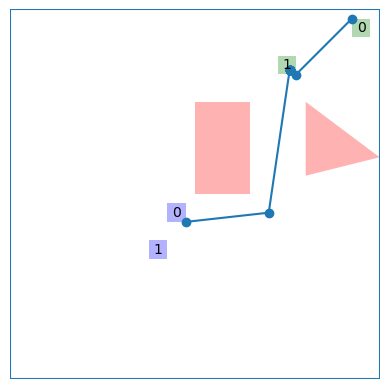

In [163]:
ax = plt.gca()
draw_env(env, ax)
ax.plot(x.value[0,:],x.value[1,:],marker = 'o')